In [1]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime
import pandas as pd
import numpy as np

In [187]:
start = datetime.datetime(2020, 5, 1)
end = datetime.datetime(2021, 2, 25)

In [188]:
btc = web.DataReader('BTC-USD', 'yahoo', start, end)
btc = btc[~btc.index.duplicated()]
eth = web.DataReader('ETH-USD', 'yahoo', start, end)
eth = eth[~eth.index.duplicated()]
ada = web.DataReader('ADA-USD', 'yahoo', start, end)
ada = ada[~ada.index.duplicated()]
bnb = web.DataReader('BNB-USD', 'yahoo', start, end)
bnb = bnb[~bnb.index.duplicated()]
dot = web.DataReader('DOT1-USD', 'yahoo', start, end)
dot = dot[~dot.index.duplicated()]

In [189]:
btc_len = btc.shape[0]
eth_len = eth.shape[0]
ada_len = ada.shape[0]
bnb_len = bnb.shape[0]
dot_len = dot.shape[0]

In [190]:
coins = pd.concat([btc['Close'], eth['Close'], ada['Close'], bnb['Close'], dot['Close']], axis=1)

In [191]:
coins.columns = ['BTC', 'ETH', 'ADA', 'BNB', 'DOT']
returns = coins/coins.shift(1)
logReturns = np.log(returns)

In [192]:
btc

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-30,9048.023438,8667.763672,8672.782227,8864.766602,4.406839e+10,8864.766602
2020-05-01,9007.187500,8811.366211,8869.057617,8988.596680,4.013439e+10,8988.596680
2020-05-02,9167.781250,8830.971680,8983.614258,8897.468750,4.710179e+10,8897.468750
2020-05-03,8956.906250,8645.024414,8895.745117,8912.654297,4.571880e+10,8912.654297
2020-05-04,9062.415039,8856.827148,8912.832031,9003.070312,4.314846e+10,9003.070312
...,...,...,...,...,...,...
2021-02-22,57533.390625,48967.566406,57532.738281,54207.320312,9.205242e+10,54207.320312
2021-02-23,54204.929688,45290.589844,54204.929688,48824.425781,1.061025e+11,48824.425781
2021-02-24,51290.136719,47213.500000,48835.085938,49705.332031,6.369552e+10,49705.332031


In [193]:
noOfPortfolios = 10000
weight = np.zeros((noOfPortfolios, 5))

expectedReturn = np.zeros(noOfPortfolios)
expectedVolatility = np.zeros(noOfPortfolios)
sharpeRatio = np.zeros(noOfPortfolios)

meanLogRet = logReturns.mean()
Sigma = logReturns.cov()

for k in range(noOfPortfolios):
    # generate random weight vector
    w = np.array(np.random.random(5))
    w = w / np.sum(w)
    weight[k,:] = w
    
    # exepcted log return
    expectedReturn[k] = np.sum(meanLogRet * w)

    # excpected volatility
    expectedVolatility[k] = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    
    # shapre ratio
    sharpeRatio[k] = expectedReturn[k]/expectedVolatility[k]
    

In [194]:
maxIndex = sharpeRatio.argmax()
random_alocs = weight[maxIndex,:]*100

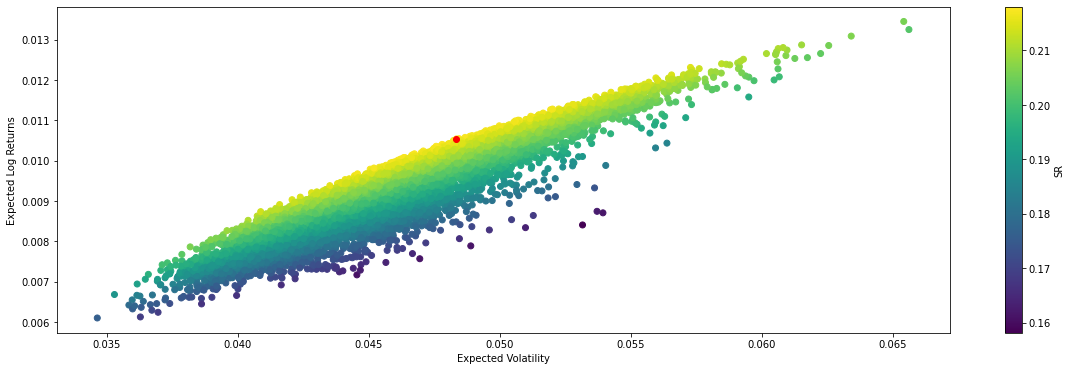

In [195]:
plt.figure(figsize=(20, 6))
plt.scatter(expectedVolatility, expectedReturn, c=sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVolatility[maxIndex], expectedReturn[maxIndex], c='red')
plt.show()

In [196]:
def negativeSR(w):
    w = np.array(w)
    R = np.sum(meanLogRet*w)
    V = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    SR = R/V
    return -1*SR

def checkSumToOne(w):
    return np.sum(w)-1

In [197]:
w0 = [0.25, 0.25, 0.25, 0.25, 0.25]
bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
constraints = ({'type':'eq', 'fun':checkSumToOne})

In [198]:
w_opt = minimize(negativeSR, w0, method='SLSQP', bounds=bounds, constraints=constraints)
w_opt

     fun: -0.21814310164868636
     jac: array([-0.00011189,  0.03113898,  0.00035872, -0.00058074,  0.0001038 ])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.29811856, 0.        , 0.24032902, 0.14720042, 0.314352  ])

In [199]:
opt_alocs = w_opt.x*100

In [200]:
for coin, opt_aloc, random_aloc in zip(coins.columns, opt_alocs, random_alocs):
    print(f"Invest ({random_aloc:.1f}%) {opt_aloc:.1f}% in {coin}")

Invest (27.8%) 29.8% in BTC
Invest (0.1%) 0.0% in ETH
Invest (23.1%) 24.0% in ADA
Invest (15.5%) 14.7% in BNB
Invest (33.5%) 31.4% in DOT
